In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 36.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pickle
import contextily as ctx
from sklearn.metrics import silhouette_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

from sklearn.decomposition import PCA

from shapely.geometry import MultiPoint
from shapely.geometry import Point
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from geopandas import GeoDataFrame
from scipy.spatial.distance import cdist

##CLEANING DATASET DARI OSM (BERISI LATITUDE DAN LONGITUDE 15 KECAMATAN DI PEKANBARU)

###Kecamatan

In [ ]:
data_kec = pd.read_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/location_classification/kecamatan_pku.xlsx")

In [ ]:
data_kec.head()

,@id,admin_level,boundary,is_in:city,is_in:country,is_in:province,name,name:en,name:id,name:ms-Arab,...,latitude,longitude,addr:district,addr:province,name:nl,old_name,alt_name,ref,alt_name:en,@relations
0,relation/8269824,6.0,administrative,Pekanbaru,ID,RI,Kulim,Kulim District,Kecamatan Kulim,کچامتن کوليم,...,0.474195,101.536858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,relation/11922435,6.0,administrative,NaN,NaN,NaN,Minas,NaN,NaN,NaN,...,0.783493,101.502879,Siak,Riau,NaN,NaN,NaN,NaN,NaN,NaN
2,relation/17859274,6.0,administrative,Pekanbaru,ID,Riau,Marpoyan Damai,Marpoyan Damai District,NaN,کچامتن مرڤويان دامي,...,0.467149,101.436899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,relation/17872023,6.0,administrative,Pekanbaru,ID,RI,Rumbai Timur,East Rumbai District,NaN,کچامتن رومبي تيمور,...,0.618484,101.519750,NaN,NaN,District Oost Rumbai,NaN,NaN,NaN,NaN,NaN
4,relation/17889199,6.0,administrative,Pekanbaru,ID,RI,Binawidya,Binawidya District,Kecamatan Binawidya,کچامتن بيناويديا,...,0.495118,101.384132,NaN,NaN,District Binawidya,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_kec = data_kec.dropna(subset=["is_in:city"])

In [ ]:
selected_columns = data_kec[["name", "admin_level", "latitude", "longitude"]]

In [ ]:
selected_columns = selected_columns.rename(columns={"name":"placeName", "latitude":"placeLatitude", "longitude":"placeLongitude"})

In [ ]:
selected_columns.head(20)

,placeName,admin_level,placeLatitude,placeLongitude
0,Kulim,6.0,0.474195,101.536858
2,Marpoyan Damai,6.0,0.467149,101.436899
3,Rumbai Timur,6.0,0.618484,101.519750
4,Binawidya,6.0,0.495118,101.384132
5,Tuah Madani,6.0,0.460896,101.381359
6,Payung Sekaki,6.0,0.528463,101.398830
7,Rumbai,6.0,0.580678,101.391103
8,Rumbai Barat,6.0,0.634143,101.394120
9,Bukit Raya,6.0,0.467193,101.463765
10,Sail,6.0,0.513473,101.459982


In [ ]:
selected_columns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 0 to 15
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   placeName       15 non-null     object 
 1   admin_level     15 non-null     float64
 2   placeLatitude   15 non-null     float64
 3   placeLongitude  15 non-null     float64
dtypes: float64(3), object(1)
memory usage: 600.0+ bytes


In [ ]:
selected_columns.to_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/location_classification/DATASET_KECEMATAN_LATLON.xlsx")

###Kelurahan

In [ ]:
data_lurah = pd.read_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/location_classification/kelurahan.xlsx")

In [ ]:
data_lurah.head()

,X,Y,id,@id,@relations,admin_level,alt_name,alt_name:en,boundary,is_in:city,...,name:nl,official_name,old_name,postal_code,ref,reference,source,type,wikidata,@geometry
0,101.440110,0.565002,relation/4185337,relation/4185337,NaN,7.0,NaN,NaN,administrative,Pekanbaru,...,NaN,Kelurahan Limbungan Baru,NaN,28261.0,NaN,Perda No. 4 Tahun 2003,NaN,boundary,Q12494903,NaN
1,101.442285,0.637909,relation/8269819,relation/8269819,NaN,7.0,NaN,NaN,administrative,Pekanbaru,...,Onderdistrict Oost Muara Fadjar,Kelurahan Muara Fajar Timur,NaN,NaN,Peta Administrasi Rumbai Barat,NaN,Peraturan Daerah Kota Pekanbaru 2/2020 Tentang...,boundary,Q13544830,NaN
2,101.436842,0.595873,relation/8269820,relation/8269820,NaN,7.0,NaN,NaN,administrative,Pekanbaru,...,NaN,Kelurahan Lembah Damai,NaN,NaN,"BPS, prov=14, kota=71, kec=081, kel=004, kode2...",NaN,NaN,boundary,Q12494387,NaN
3,101.469050,0.571374,relation/8269821,relation/8269821,NaN,7.0,NaN,NaN,administrative,Pekanbaru,...,NaN,Kelurahan Lembah Sari,NaN,NaN,"BPS, prov=14, kota=71, kec=081, kel=003, kode2...",NaN,Peraturan Daerah Kota Pekanbaru 2/2020 Tentang...,boundary,Q12494392,NaN
4,101.540614,0.600313,relation/8269822,relation/8269822,NaN,7.0,NaN,NaN,administrative,Pekanbaru,...,NaN,Kelurahan Tebing Tinggi Okura,NaN,NaN,"BPS, prov=14, kota=71, kec=081, kel=006, kode2...",NaN,Peraturan Daerah Kota Pekanbaru 2/2020 Tentang...,boundary,Q12520243,NaN


In [ ]:
data_lurah.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   X               240 non-null    float64
 1   Y               240 non-null    float64
 2   id              240 non-null    object 
 3   @id             240 non-null    object 
 4   @relations      84 non-null     object 
 5   admin_level     156 non-null    float64
 6   alt_name        20 non-null     object 
 7   alt_name:en     2 non-null      object 
 8   boundary        156 non-null    object 
 9   is_in:city      154 non-null    object 
 10  is_in:country   154 non-null    object 
 11  is_in:district  156 non-null    object 
 12  is_in:province  156 non-null    object 
 13  name            156 non-null    object 
 14  name:en         152 non-null    object 
 15  name:id         114 non-null    object 
 16  name:ms-Arab    152 non-null    object 
 17  name:nl         112 non-null    obj

In [ ]:
data_lurah = data_lurah.dropna(subset=["is_in:city"])

In [ ]:
data_lurah = data_lurah[data_lurah["is_in:city"].str.lower() == "pekanbaru"]

In [ ]:
selected = data_lurah[["official_name", "admin_level", "Y", "X"]]

In [ ]:
selected = selected.rename(columns={"official_name":"placeName", "Y":"placeLatitude", "X":"placeLongitude"})

In [ ]:
selected.head(159)

,placeName,admin_level,placeLatitude,placeLongitude
0,Kelurahan Limbungan Baru,7.0,0.565002,101.440110
1,Kelurahan Muara Fajar Timur,7.0,0.637909,101.442285
2,Kelurahan Lembah Damai,7.0,0.595873,101.436842
3,Kelurahan Lembah Sari,7.0,0.571374,101.469050
4,Kelurahan Tebing Tinggi Okura,7.0,0.600313,101.540614
...,...,...,...,...
151,Kelurahan Kampung Melayu,7.0,0.510826,101.434868
152,Kelurahan Sialang Sakti,7.0,0.498800,101.506529
153,Kelurahan Bambu Kuning,7.0,0.540436,101.477063
154,Kelurahan Bencah Lesung,7.0,0.519417,101.510416


In [ ]:
selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 154 entries, 0 to 155
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   placeName       154 non-null    object 
 1   admin_level     154 non-null    float64
 2   placeLatitude   154 non-null    float64
 3   placeLongitude  154 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.0+ KB


In [ ]:
selected.to_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/location_classification/DATASET_KELURAHAN_LATLON.xlsx")

In [ ]:
df_kecamatan = pd.read_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/location_classification/DATASET_KECEMATAN_LATLON.xlsx")
df_kelurahan = pd.read_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/location_classification/DATASET_KELURAHAN_LATLON.xlsx")

In [ ]:
df_kecamatan.columns

Index(['Unnamed: 0', 'placeName', 'admin_level', 'placeLatitude',
       'placeLongitude'],
      dtype='object')

In [ ]:
df_kecamatan.drop("Unnamed: 0",  axis=1)

,placeName,admin_level,placeLatitude,placeLongitude
0,Kulim,6,0.474195,101.536858
1,Marpoyan Damai,6,0.467149,101.436899
2,Rumbai Timur,6,0.618484,101.519750
3,Binawidya,6,0.495118,101.384132
4,Tuah Madani,6,0.460896,101.381359
5,Payung Sekaki,6,0.528463,101.398830
6,Rumbai,6,0.580678,101.391103
7,Rumbai Barat,6,0.634143,101.394120
8,Bukit Raya,6,0.467193,101.463765
9,Sail,6,0.513473,101.459982


In [ ]:
df_kelurahan.head()

,Unnamed: 0,placeName,admin_level,placeLatitude,placeLongitude
0,0,Kelurahan Limbungan Baru,7,0.565002,101.440110
1,1,Kelurahan Muara Fajar Timur,7,0.637909,101.442285
2,2,Kelurahan Lembah Damai,7,0.595873,101.436842
3,3,Kelurahan Lembah Sari,7,0.571374,101.469050
4,4,Kelurahan Tebing Tinggi Okura,7,0.600313,101.540614


In [ ]:
df_kelurahan = df_kelurahan.drop("Unnamed: 0", axis=1)

#METODE CLUSTER

In [ ]:
X_train = df_kecamatan[["placeLatitude", "placeLongitude"]]
X_test = df_kelurahan[["placeLatitude", "placeLongitude"]]
y_train = df_kecamatan["placeName"]
y_labels = df_kecamatan["placeName"].reset_index(drop=True)

##K-MEANS

In [ ]:
n_clusters = y_labels.nunique()

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=15, random_state=42)

In [ ]:
predicted_kecamatan_KMEAN = kmeans.predict(X_test)

In [ ]:
centroids = kmeans.cluster_centers_
distances = cdist(centroids, X_train)
nearest_indices = distances.argmin(axis=1)
cluster_to_kecamatan = y_labels.iloc[nearest_indices].reset_index(drop=True)

In [ ]:
df_kelurahan["kec-kmeans"] = [cluster_to_kecamatan[c] for c in predicted_kecamatan_KMEAN]

In [ ]:
score = silhouette_score(X_test, predicted_kecamatan_KMEAN)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.23


Silhouette Score rendah dikarenakan ini cluster spasial (bentuk cluster tidak bulat)

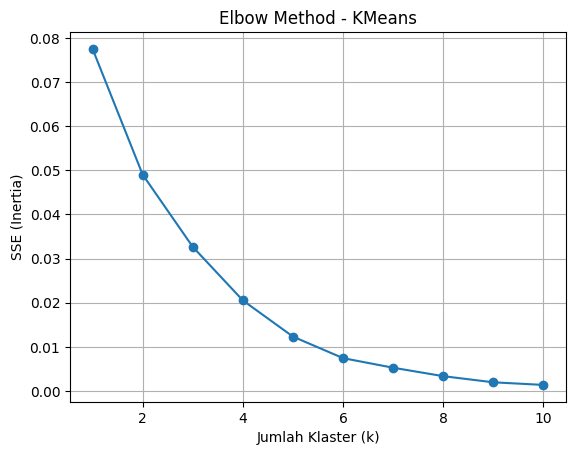

In [ ]:
sse = []
k_range = range(1, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train)
    sse.append(km.inertia_)

plt.plot(k_range, sse, marker='o')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method - KMeans')
plt.grid(True)
plt.show()

Hasil elbow menyarankan cluster 10 tapi saya menggunakan 15 cluster sesuai data kecamatan di Pekanbaru

In [ ]:
df_kelurahan.head()

,placeName,admin_level,placeLatitude,placeLongitude,kec-kmeans
0,Kelurahan Limbungan Baru,7,0.565002,101.440110,Senapelan
1,Kelurahan Muara Fajar Timur,7,0.637909,101.442285,Rumbai Barat
2,Kelurahan Lembah Damai,7,0.595873,101.436842,Rumbai
3,Kelurahan Lembah Sari,7,0.571374,101.469050,Lima Puluh
4,Kelurahan Tebing Tinggi Okura,7,0.600313,101.540614,Rumbai Timur


####Menghitung ARI (adjusted rand index) dan NMI (normalized mutual information)

In [ ]:
y_true = df_kelurahan["placeName"]
y_pred = predicted_kecamatan_KMEAN

In [ ]:
ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)

print("Adjusted Rand Index:", ari)
print("Normalized Mutual Information:", nmi)

Adjusted Rand Index: 0.15507565213487182
Normalized Mutual Information: 0.7459191750050476


ARI rendah dikarenakan ini data spasial (bentuk cluster tidak bulat melainkan mengikuti bentuk wilayah kecamatan) (-1 - 1)

NMI lumayan bagus (0 - 1)

In [ ]:
# cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true)))
# cm_df = pd.DataFrame(cm, index=sorted(set(y_true)), columns=sorted(set(y_true)))

In [ ]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix: KMeans vs Kecamatan')
# plt.xlabel('Predicted Kecamatan')
# plt.ylabel('True Kecamatan')
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

##CLUSTERING

###DATASET 40RIBU DATA USAHA DI PEKANBARU

In [ ]:
df_bangunan = pd.read_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/all_classification/final_banget_pc_70_amen.xlsx")

In [ ]:
df_bangunan.columns

Index(['Unnamed: 0', 'placeId', 'placeName', 'placeAddress',
       'placeBusinessStatus', 'placeTypes', 'placeLatitude', 'placeLongitude',
       'source', 'predicted_category_kbli'],
      dtype='object')

In [ ]:
df_bangunan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40940 entries, 0 to 40939
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               40940 non-null  int64  
 1   placeId                  40940 non-null  object 
 2   placeName                40940 non-null  object 
 3   placeAddress             40940 non-null  object 
 4   placeBusinessStatus      40940 non-null  object 
 5   placeTypes               40940 non-null  object 
 6   placeLatitude            40940 non-null  float64
 7   placeLongitude           40940 non-null  float64
 8   source                   40940 non-null  object 
 9   predicted_category_kbli  40940 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 3.1+ MB


In [ ]:
df_bangunan["kecamatan-KMEAN"] = kmeans.predict(df_bangunan[["placeLatitude", "placeLongitude"]])

In [ ]:
gdf = GeoDataFrame(df_kelurahan, geometry=gpd.points_from_xy(df_kelurahan.placeLongitude, df_kelurahan.placeLatitude))

###FIGURE DAN PLOTTING HASIL CLUSTER K-MEAN

#####1. JUMLAH BANGUNAN PER KECAMATAN

In [ ]:
jumlah_bangunan_KMEAN = df_bangunan.groupby(["kecamatan-KMEAN", "placeBusinessStatus"]).size().unstack(fill_value=0)

In [ ]:
jumlah_bangunan_KMEAN.index = jumlah_bangunan_KMEAN.index.map(cluster_to_kecamatan)

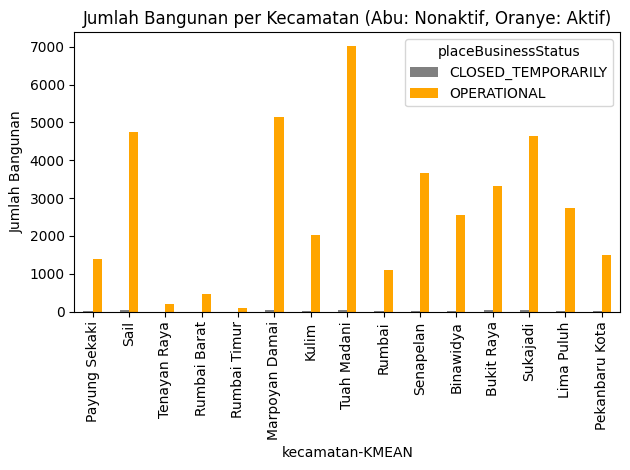

In [ ]:
jumlah_bangunan_KMEAN.plot(kind="bar", stacked=False, color=["gray", "orange"])
plt.title("Jumlah Bangunan per Kecamatan (Abu: Nonaktif, Oranye: Aktif)")
plt.ylabel("Jumlah Bangunan")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#####2. HASIL CLUSTERING

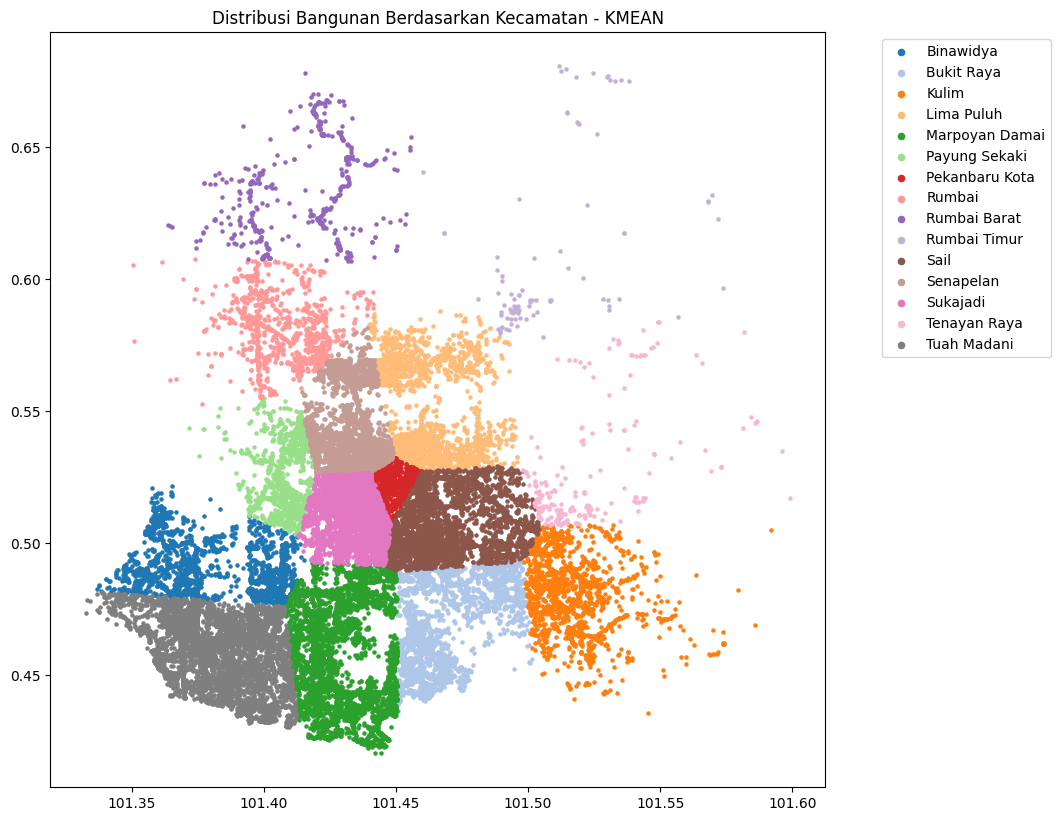

In [ ]:
gdf = gpd.GeoDataFrame(df_bangunan, geometry=gpd.points_from_xy(df_bangunan["placeLongitude"], df_bangunan["placeLatitude"]))
gdf["kecamatan-KMEAN"] = gdf["kecamatan-KMEAN"].map(cluster_to_kecamatan)
fig, ax = plt.subplots(figsize=(10, 10))

colors = sns.color_palette("tab20", n_colors=15)
for i, (kecamatan, group) in enumerate(gdf.groupby("kecamatan-KMEAN")):
    group.plot(ax=ax, markersize=5, color=colors[i], label=kecamatan)

plt.legend(markerscale=2, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title("Distribusi Bangunan Berdasarkan Kecamatan - KMEAN")
plt.show()

#####3. PLOTTING 5 KATEGORI USAHA TERBANYAK PER KECAMATAN

In [ ]:
dominant_kbli = df_bangunan.groupby("kecamatan-KMEAN")["predicted_category_kbli"].agg(lambda x: x.value_counts().idxmax())
kbli_counts = df_bangunan.groupby(["kecamatan-KMEAN", "predicted_category_kbli"]).size().reset_index(name='count')

In [ ]:
gdf["kecamatan-KMEAN"] = gdf["kecamatan-KMEAN"].map(cluster_to_kecamatan)
df_bangunan["kecamatan-KMEAN"] = df_bangunan["kecamatan-KMEAN"].map(cluster_to_kecamatan)

<ipython-input-76-d3d222e91d3f>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, "count"))
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/pyth

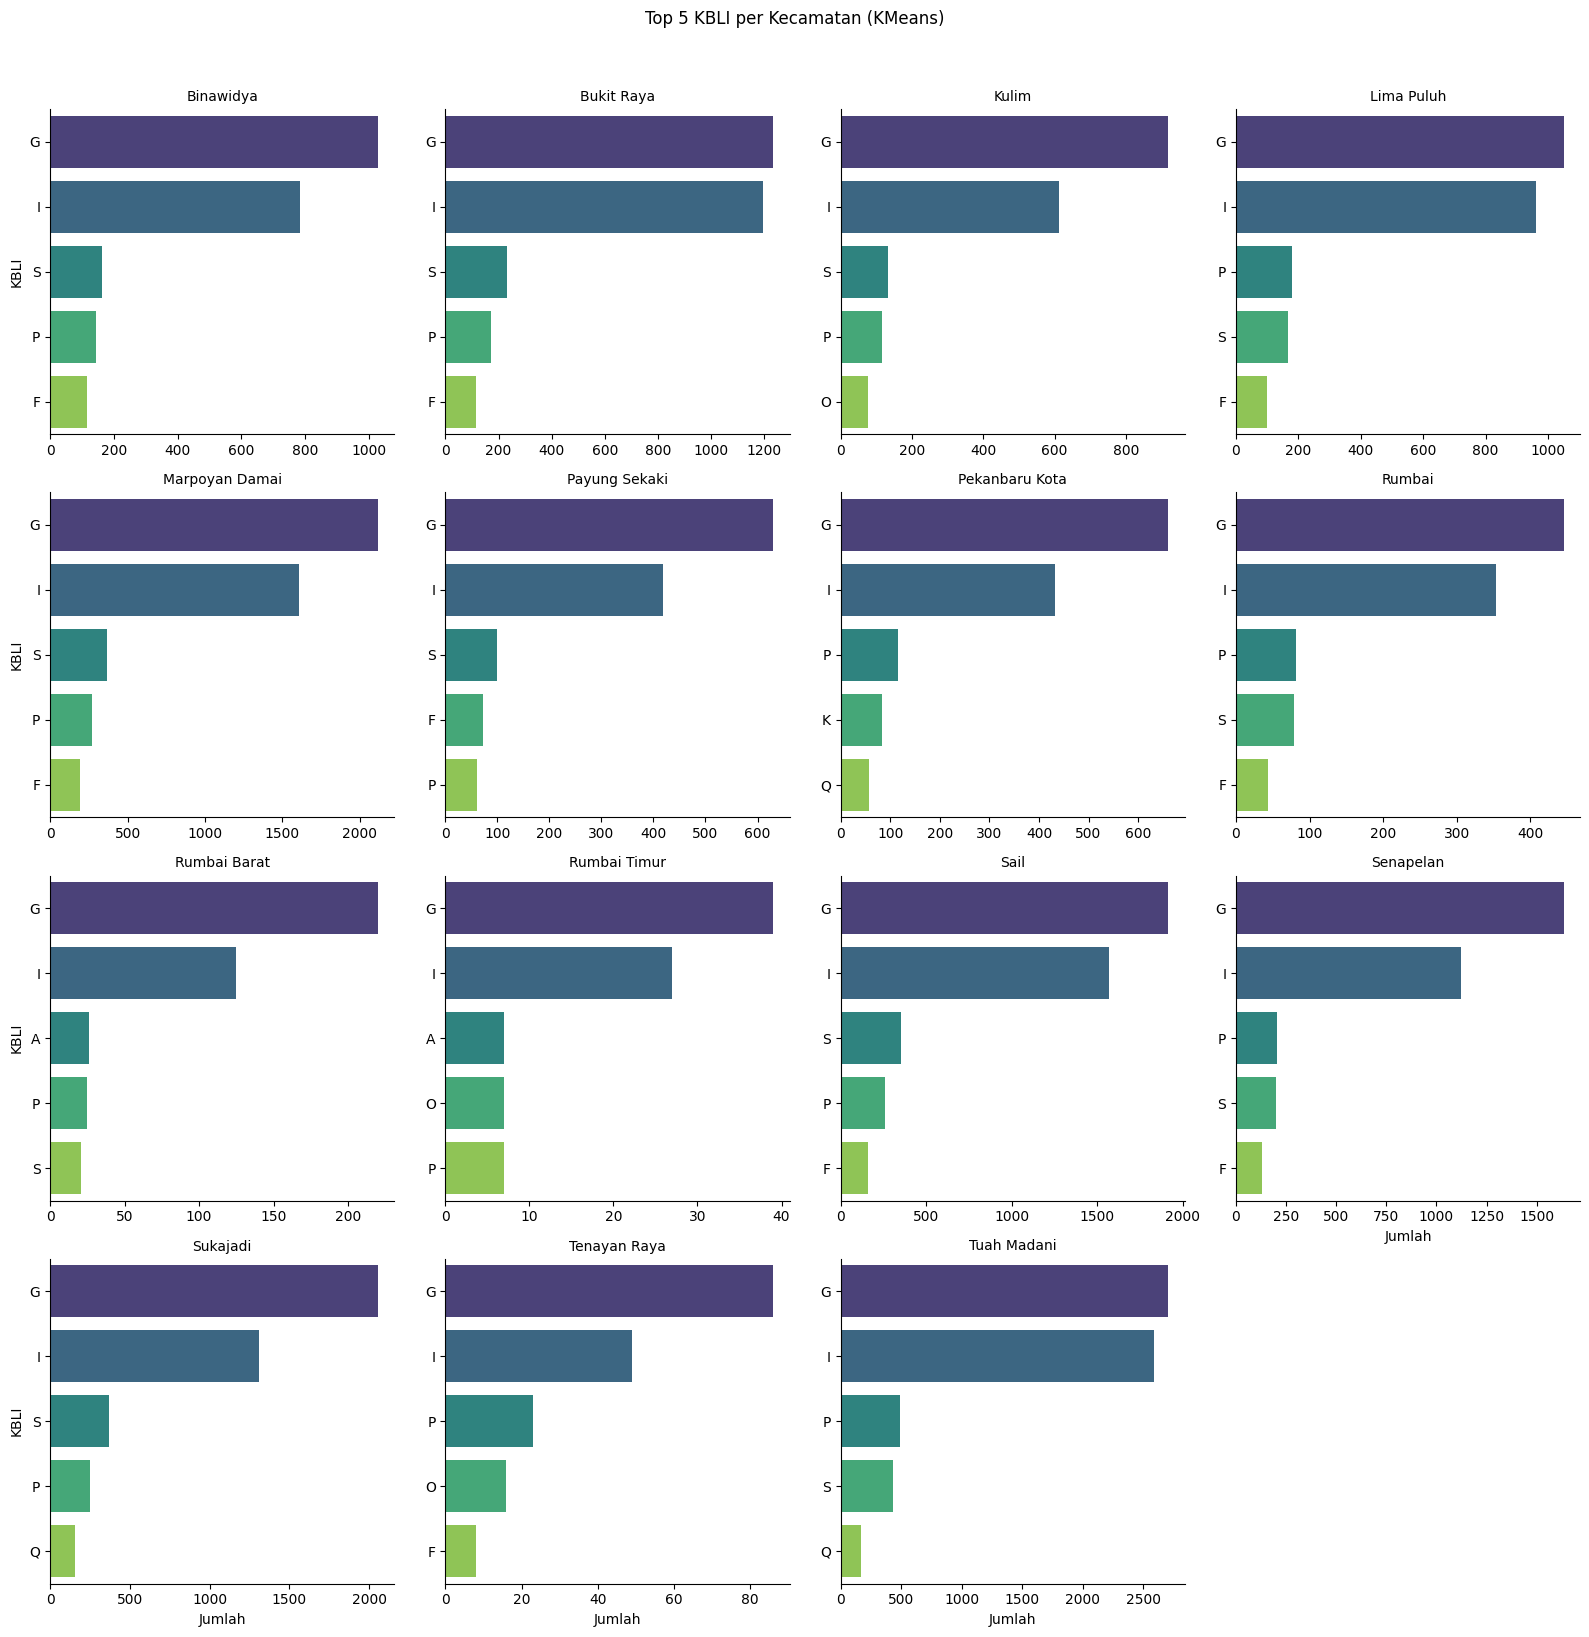

In [ ]:
top_kbli = (
    kbli_counts.groupby("kecamatan-KMEAN")
    .apply(lambda x: x.nlargest(5, "count"))
    # .reset_index(drop=True)
)

g = sns.FacetGrid(top_kbli, col="kecamatan-KMEAN", col_wrap=4, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.barplot, x="count", y="predicted_category_kbli", palette="viridis")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Jumlah", "KBLI")
g.fig.suptitle("Top 5 KBLI per Kecamatan (KMeans)", y=1.02)
plt.tight_layout()
plt.show()

#####4. PLOT KE MAP PEKANBARU

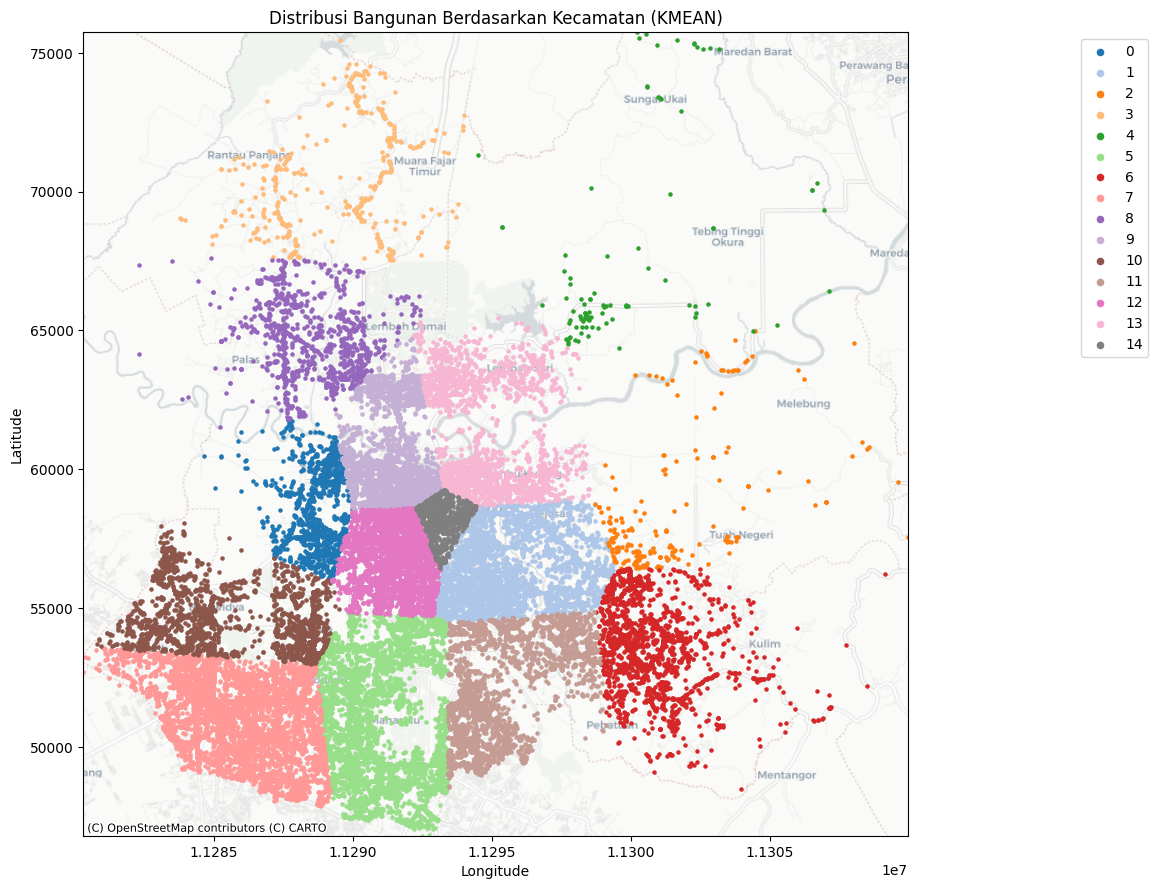

In [ ]:
gdf = gpd.GeoDataFrame(df_bangunan, geometry=gpd.points_from_xy(df_bangunan["placeLongitude"], df_bangunan["placeLatitude"]))
gdf = gdf.set_crs(epsg=4326).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
colors = sns.color_palette("tab20", n_colors=15)

for i, (kecamatan, group) in enumerate(gdf.groupby("kecamatan-KMEAN")):
    group.plot(ax=ax, markersize=5, color=colors[i], label=kecamatan)

ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])
ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.legend(markerscale=2, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title("Distribusi Bangunan Berdasarkan Kecamatan (KMEAN)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

In [ ]:
with open("model_kmean_kecamatan.pkl", "wb") as f:
  pickle.dump(kmeans, f)

In [ ]:
df_bangunan.to_excel("/content/drive/MyDrive/BPS_PROJECT/PROCESSED/location_classification/DATASET_CLUSTER_LOKASI_KMEAN.xlsx")

In [ ]:
gdf.to_file("kecamatan_boundary.geojson", driver='GeoJSON')

In [ ]:
df_bangunan[["placeLatitude", "placeLongitude", "kecamatan-KMEAN"]].to_json("boundary.json", orient="records")
